
# Bug hunting with Lauge.
_File Description_

In this file, we will hunt systematically for bugs in the entire code base.
When making changes to the code, please tun the relevant sections in this file (preferably all of them) to make 
sure that nothing breaks, and that it yields the results that you expect.


In [31]:
# imports
import os
import sys
import time
import json
import math

from tqdm import tqdm
from PIL import Image
import torch as th
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from model_camera_calibration import CameraCalibrationModel
from model_camera_extrinsics import CameraExtrinsics
from model_interpolation_architecture import NerfModel, PositionalEncoding, BarfPositionalEncoding, IdentityPositionalEncoding, FourierFeatures
from model_interpolation import NerfInterpolation
from dataset import ImagePoseDataset
from data_module import ImagePoseDataModule
from Lie_barf import Lie

## Dataset

In [2]:
# list all methods of imageposedataset
methods = [method for method in dir(ImagePoseDataset) if callable(getattr(ImagePoseDataset, method)) and not method.startswith("__")]
print("\n".join(methods))


_apply_noise
_get_cam_origs_and_directions
_get_directions_meshgrid
_load_camera_info
_load_images
_meshgrid_to_world
_screw_up_original_camera_poses_for_testing_validation_transform_in_CameraCalibrationModel
_transform_camera_to_world
gaussian_blur
subset_dataset


### `_load_camera_info()`

In [3]:
try:
    ImagePoseDataset._load_camera_info("../data/lego/transforms_train_modified.json", 200)
except ValueError as e:
    print(f"Camera test passed. Found error:\n  ValueError: {e}\nas expected when trying to load scaled cam to world matrices")
except Exception as e:
    print(f"Camera test failed. Found error:\n  {e} \nwhen trying to load scaled cam to world matrices")

Camera test passed. Found error:
  ValueError: camera_to_world matrices are expected to have scale 1, found 2.0 in ./train/r_0
as expected when trying to load scaled cam to world matrices


In [4]:
# test only _load_camera_info

img_names = "r_0", "r_1"

camera_data_modified = json.loads(open("../data/lego/transforms_train.json").read())
_, cam_to_world_test = ImagePoseDataset._load_camera_info("../data/lego/transforms_train.json", 200)
cam_to_world_true = {data["file_path"].split("/")[-1]: th.tensor(data["transform_matrix"]) for data in camera_data_modified["frames"]}

for img_name in img_names:
    assert th.allclose(cam_to_world_test[img_name][:3,:3], cam_to_world_true[img_name][:3,:3]), f"Rotation matrix not equal for {img_name}"
    assert th.allclose(cam_to_world_test[img_name][:3,3]/cam_to_world_test[img_name][3,3],
                       cam_to_world_true[img_name][:3,3]/cam_to_world_true[img_name][3,3]), f"Translation matrix not equal for {img_name}"
print("Camera info test passed")


Camera info test passed


### `_get_directions_meshgrid()`

In [5]:
meshgrid = ImagePoseDataset._get_directions_meshgrid(image_height=4, image_width=2, focal_length=4)
target_meshgrid_raw = th.tensor([
                                [-1/8,  3/8, -1],
                                [ 1/8,  3/8, -1],
                                [-1/8,  1/8, -1],
                                [ 1/8,  1/8, -1],
                                [-1/8, -1/8, -1],
                                [ 1/8, -1/8, -1],
                                [-1/8, -3/8, -1],
                                [ 1/8, -3/8, -1],
                            ])
target_meshgrid_normalized = target_meshgrid_raw/th.linalg.vector_norm(target_meshgrid_raw, dim=1, keepdim=True)

assert th.allclose(meshgrid, target_meshgrid_normalized), "Meshgrid not equal"
print("Meshgrid test passed")

Meshgrid test passed


In [6]:
target_meshgrid_raw.view(4,2,3)[: , 0 , 1]

tensor([ 0.3750,  0.1250, -0.1250, -0.3750])

### `_get_cam_origs_and_directions()`

In [7]:
R = CameraExtrinsics.so3_to_SO3(th.tensor([0.9, 0.2, 0.3]))
t = th.tensor([2.3, 0.2, 1.3])
cam_to_world = th.eye(4)
cam_to_world[:3,:3] = R
cam_to_world[:3,3] = t

d = R @ th.tensor([0,0,-1.])
o = t

o_hat, d_hat = ImagePoseDataset._get_cam_origs_and_directions(cam_to_world.unsqueeze(0))

assert th.allclose(o, o_hat), "Camera origin not equal"
assert th.allclose(d, d_hat), "Camera direction not equal"
print("Camera origin and direction test passed")

Camera origin and direction test passed


### `_meshgrid_to_world()`

In [8]:
meshgrid = th.tensor([[0,0.,-1],
                      [0,0.,-1]])
world_origs, world_dir = ImagePoseDataset._meshgrid_to_world(meshgrid, cam_to_world.unsqueeze(0))
assert th.allclose(world_dir, d.repeat(2,1)), "Directions to world not equal"
assert th.allclose(world_origs, o.repeat(2,1)), "Origins to world not equal"
print("Meshgrid to world test passed")

Meshgrid to world test passed


### `_apply_noise()`

In [9]:
dataset = ImagePoseDataset(15, 10, "../data/lego/train/", "../data/lego/transforms_train.json", 1, th.tensor([0,0,0.]), 0.15, 0.15, 42)

In [10]:
camera_origs, camera_dirs = dataset.camera_origins, dataset.camera_directions
camera_origs_noisy, camera_dirs_noisy = dataset.camera_origins_noisy, dataset.camera_directions_noisy

ray_origs, ray_dirs_mean = dataset.ray_origins, dataset.ray_directions
ray_origs_noisy, ray_dirs_noisy_mean = dataset.ray_origins_noisy, dataset.ray_directions_noisy



In [11]:
assert th.allclose(camera_origs.unsqueeze(1).repeat(1,ray_origs.shape[1],1),ray_origs), "Camera origins not equal to ray origins"

ray_origs_errors = ((ray_origs - ray_origs_noisy)**2).sum(dim=-1).mean()**0.5
camera_origs_errors = ((camera_origs - camera_origs_noisy)**2).sum(dim=-1).mean()**0.5

ray_dirs_cossim = (ray_dirs_mean*ray_dirs_noisy_mean).sum(dim=-1)/th.linalg.vector_norm(ray_dirs_mean, dim=-1)/th.linalg.vector_norm(ray_dirs_noisy_mean, dim=-1)
ray_dirs_angle = (th.acos(ray_dirs_cossim)**2).mean()**0.5
camera_dirs_cossim = (camera_dirs*camera_dirs_noisy).sum(dim=-1)/th.linalg.vector_norm(camera_dirs, dim=-1)/th.linalg.vector_norm(camera_dirs_noisy, dim=-1)
camera_dirs_angle = (th.acos(camera_dirs_cossim)**2).mean()**0.5

print(f"Ray origins error: {ray_origs_errors:.4f}")
print(f"Camera origins error: {camera_origs_errors:.4f}")

print(f"Ray directions angle: {ray_dirs_angle*180/th.pi:.4f}")
print(f"Camera directions angle: {camera_dirs_angle*180/th.pi:.4f}")


Ray origins error: 0.2472
Camera origins error: 0.2472
Ray directions angle: 11.7160
Camera directions angle: 11.7020


### `subset_dataset()`

In [12]:
dataset = ImagePoseDataset(200,
                           100,
                           "../data/lego/train/",
                           "../data/lego/transforms_train.json",
                           1, th.tensor([0,0,0.]),
                           0.15, 0.15, 42,
                           gaussian_blur_sigmas=[20, 5, 0.])

In [13]:
image_names1 = [f"r_{i}" for i in [1,5,4,23,29,78,3,55,12,13,15]]
image_names2 = [image_names1[i] for i in [0,7,10,2]]

dataset1 = dataset.subset_dataset(image_names1)
dataset2 = dataset1.subset_dataset(image_names2)

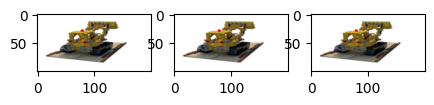

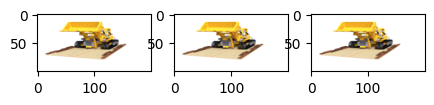

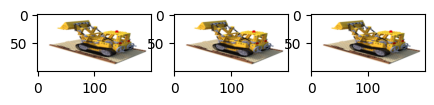

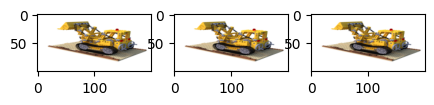

Image name to index test passed
Index to index test passed
subset_dataset test passed


In [14]:
# test the image name to index
for i, img_name in enumerate(image_names2):
    fig = plt.figure(figsize=(5, 2))
    images = []
    for j, d in enumerate([dataset, dataset1, dataset2]):
        fig.add_subplot(1, 3, j+1)
        im = d.images[d.image_name_to_index[img_name], :, :, -1]
        assert im.shape[:2] == (d.image_height, d.image_width), f"Image {img_name} has wrong shape {im.shape}"
        plt.imshow(im)
        images.append(im)

    assert th.allclose(images[0], images[1]), f"Image {img_name} not equal for dataset1"
    assert th.allclose(images[0], images[2]), f"Image {img_name} not equal for dataset2"
    plt.show()

print("Image name to index test passed")

# test index to index
for name in image_names2:
    # get the index in datasets
    idx = dataset.image_name_to_index[name]
    idx1 = dataset1.index_to_index[dataset1.image_name_to_index[name]]
    idx2 = dataset2.index_to_index[dataset2.image_name_to_index[name]]

    assert idx == idx1, f"Index {idx} not equal to index1 {idx1} for image {name}"
    assert idx == idx2, f"Index {idx} not equal to index2 {idx2} for image {name}"

print("Index to index test passed")

print("subset_dataset test passed")



### Final check

In [15]:
height, width = 79, 123

# instatiate the dataset
dataset = ImagePoseDataset(
                           width,
                           height,
                           "../data/lego/train/", 
                           "../data/lego/transforms_train.json", 
                           1, 
                           th.tensor([0,0,0.]), 
                           0.15, 
                           0.15, 
                           42, 
                           gaussian_blur_sigmas=[20, 5, 0.],
                           verbose=True)



Loading camera info...


Loading images: 100%|██████████| 100/100 [00:00<00:00, 1943.48it/s]


Converting to tensor: 100%|██████████| 100/100 [00:00<00:00, 2394.26it/s]


Generating rays...
Applying noise...
Done loading data!


In [16]:
transforms = json.loads(open("../data/lego/transforms_train_modified.json").read())
camera_angle_x = transforms["camera_angle_x"]
focal_length = (width / 2) / math.tan(camera_angle_x / 2)
assert dataset.focal_length == focal_length, "Focal length not equal"
print("Focal length test passed")

Focal length test passed


In [17]:
idx = th.tensor([((width - 1)/2 - j, -(height-1)/2 + i) for i in range(height) for j in range(width)])
alpha = (th.linalg.vector_norm(idx, dim=1)**2 + focal_length**2)**0.5

ray_dirs = dataset.ray_directions
ray_dirs = ray_dirs * alpha.unsqueeze(0).unsqueeze(-1)

for img_idx in tqdm(range(dataset.n_images)):
    for i in range(height):
        vertical_diff = ray_dirs[img_idx, width*i:width*(i+1)-1] - ray_dirs[img_idx, width*i+1:width*(i+1)]
        vertical_diff = th.linalg.vector_norm(vertical_diff, dim=-1)
        assert (vertical_diff.max() - 1).abs() < 1e-4, f"Vertical diff not equal to 1 for image {img_idx} - was {vertical_diff.max()}"

        if i != 0:
            horizontal_diff = ray_dirs[img_idx, width*(i-1):width*i] - ray_dirs[img_idx, width*i:width*(i+1)]
            horizontal_diff = th.linalg.vector_norm(horizontal_diff, dim=-1)
            assert (horizontal_diff.max() - 1).abs() < 1e-4, f"Horizontal diff not equal to 1 for image {img_idx} - was {horizontal_diff.max()}"



 16%|█▌        | 16/100 [00:00<00:00, 154.29it/s]

100%|██████████| 100/100 [00:00<00:00, 155.93it/s]


In [18]:
assert th.allclose(th.linalg.vector_norm(dataset.ray_directions.view(-1, 3), ord=2, dim=1),
                   th.ones(dataset.ray_directions.view(-1, 3).shape[0])), "Ray directions not normalized"

ray_dirs_mean = dataset.ray_directions.mean(dim=1)
ray_dirs_mean = ray_dirs_mean / th.linalg.vector_norm(ray_dirs_mean, ord=2, dim=1, keepdim=True)

assert th.allclose(dataset.camera_directions, ray_dirs_mean), "Camera directions not equal to ray directions"

print("Camera directions compared to ray directions test passed")

Camera directions compared to ray directions test passed


In [19]:
assert th.allclose(th.linalg.vector_norm(dataset.ray_directions_noisy.view(-1, 3), ord=2, dim=1),
                   th.ones(dataset.ray_directions.view(-1, 3).shape[0])), "Ray directions not normalized"


ray_dirs_noisy_mean = dataset.ray_directions_noisy.mean(dim=1)
ray_dirs_noisy_mean = ray_dirs_noisy_mean / th.linalg.vector_norm(ray_dirs_noisy_mean, ord=2, dim=1, keepdim=True)

assert th.allclose(dataset.camera_directions_noisy, ray_dirs_noisy_mean), "Camera directions not equal to noisy ray directions"

print("Noisy camera directions compared to noisy ray directions test passed")


Noisy camera directions compared to noisy ray directions test passed


## Camera Extrinsics

### `so3_to_SO3`: ours vs BARF

In [20]:
lie = Lie()

params = th.randn(1000, 3, requires_grad=True)*th.rand(1000,1)*3

R_barf = lie.so3_to_SO3(params)
R_ours = CameraExtrinsics.so3_to_SO3(params)

barf_error = (th.matmul(R_barf.permute(0,2,1), R_barf) - th.eye(3).unsqueeze(0)).abs().max()
ours_error = (th.matmul(R_ours.permute(0,2,1), R_ours) - th.eye(3).unsqueeze(0)).abs().max()

print(f"BARF: max(R.T @ R) = {barf_error:.3e}")
print(f"ours: max(R.T @ R) = {ours_error:.3e}")

assert ours_error < 1e-4, "Our implementation not correct"

print("so3_to_SO3 test passed")

BARF: max(R.T @ R) = 1.546e+00
ours: max(R.T @ R) = 1.311e-05
so3_to_SO3 test passed


In [21]:
n_param_samples = 301
n_v_samples = 101


def loss(params, v, s03_to_SO3) -> th.Tensor:
    R = s03_to_SO3(params)
    v = th.matmul(R.unsqueeze(0), v).view(-1,3)
    l = th.nn.functional.mse_loss(v, th.ones_like(v))
    l = l*(th.log(l) - 1)
    return l

params1d = th.stack(
                   (
                   2.4*th.ones(n_param_samples, requires_grad=True),
                   th.linspace(-0.1, 7, n_param_samples, requires_grad=True), 
                   4.3*th.ones(n_param_samples, requires_grad=True),
                   ),
                   dim = 1).view(-1,3)
params1d.retain_grad()

params2d = th.stack(
                    (*th.meshgrid(
                        th.linspace(-0.1, 2.3, n_param_samples, requires_grad=True), 
                        th.linspace(-0.1, 2.3, n_param_samples, requires_grad=True), indexing="ij"
                    ),
                   0.1*th.ones((n_param_samples, n_param_samples), requires_grad=True),),
                   dim = 1).view(-1,3)
params2d.retain_grad()

v = th.randn(n_v_samples, 1, 3, 1, requires_grad=True)

grads = []

for pars in [params1d, params2d]:
    grads.append([])
    for so3_to_SO3 in [lie.so3_to_SO3, CameraExtrinsics.so3_to_SO3]:
        pars.grad = None
        l = loss(pars, v, so3_to_SO3)
        l.backward(retain_graph=True)
        grads[-1].append(pars.grad)


In [22]:
print([th.sum(th.isnan(grad)) for i in range(len(grads)) for grad in grads[i]])
[grad.shape for i in range(len(grads)) for grad in grads[i]]


[tensor(0), tensor(0), tensor(0), tensor(0)]


[torch.Size([301, 3]),
 torch.Size([301, 3]),
 torch.Size([90601, 3]),
 torch.Size([90601, 3])]

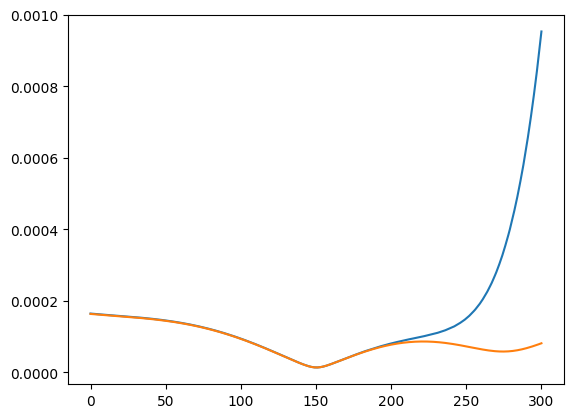

tensor(1.) tensor(1.)


In [23]:
# grad_ours_norm = th.linalg.vector_norm(grad_ours, dim=1)
# grad_barf_norm = th.linalg.vector_norm(grad_barf, dim=1)

grad_norms1d = [th.linalg.vector_norm(grad, dim=-1) for grad in grads[0]]
grad_norms2d = [th.linalg.vector_norm(grad, dim=-1) for grad in grads[1]]

# plt.plot(grad_ours_norm.detach())
# plt.plot(grad_barf_norm.detach())

plt.plot(grad_norms1d[0].detach())
plt.plot(grad_norms1d[1].detach())
plt.show()

ratio = grad_norms2d[0].detach().view(n_param_samples, n_param_samples)/grad_norms2d[0].detach().view(n_param_samples, n_param_samples)
print(ratio.max(), ratio.min())
plt.show()

## Data Module

In [27]:
dm = ImagePoseDataModule("../data/lego/", 60, 59, rotation_noise_sigma=0.1, translation_noise_sigma=0.1, batch_size=100, num_workers=2, gaussian_blur_sigmas=[20, 5, 0.], verbose=True)

In [28]:
dm.setup("fit")

Loading camera info...


Loading images: 100%|██████████| 100/100 [00:00<00:00, 1915.59it/s]


Converting to tensor: 100%|██████████| 100/100 [00:00<00:00, 2777.72it/s]


Generating rays...
Applying noise...
Done loading data!
Loading camera info...


Converting to tensor: 100%|██████████| 100/100 [00:00<00:00, 3635.52it/s]

Generating rays...
Applying noise...
Done loading data!


## Nerf model
_the underlying model_

In [87]:
pe_pos = FourierFeatures(10)
pe_dir = FourierFeatures(3)
n_hiddens = th.Tensor([126, 256])
hidden_dims = th.Tensor([128, 258])
delayed_directions = th.Tensor([True, False])
delayed_densities = th.Tensor([True, False])
n_segmentss = th.Tensor([1, 3])

meshgrid = th.meshgrid(n_hiddens,
                                hidden_dims,
                                delayed_densities,
                                delayed_directions,
                                n_segmentss,
                                indexing="ij")

models: list[NerfModel] = []

for (n_hidden,
     hidden_dim,
     delayed_direction,
     delayed_density,
     n_segments) in tqdm(zip(*tuple(map(lambda x: x.flatten(), meshgrid))), desc="Creating models", total=meshgrid[0].numel()):
    n_hidden = int(n_hidden)
    hidden_dim = int(hidden_dim)
    delayed_density = bool(delayed_density)
    delayed_direction = bool(delayed_direction)
    n_segments = int(n_segments)
    models.append(NerfModel(n_hidden, hidden_dim, delayed_direction, delayed_density, n_segments, pe_pos, pe_dir))



Creating models:   9%|▉         | 3/32 [00:00<00:01, 24.52it/s]

Creating models: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


In [89]:
n_samples = 50

col_pseudo_target = th.randn(n_samples, 3) + 10
dens_pseudo_target = th.randn(n_samples) + 10

pos = th.randn(n_samples, 3)
dir = th.randn(n_samples, 3)
grads: list[list[th.Tensor]] = []

dens_preds = []
col_preds = []

for model in tqdm(models, desc="forward passing models"):
    model.train()
    dens_pred, col_pred = model.forward(pos, dir)
    loss = th.nn.functional.mse_loss(dens_pred, dens_pseudo_target, reduction="sum") + th.nn.functional.mse_loss(col_pred, col_pseudo_target, reduction="sum")
    loss.backward()
    grads.append([par.grad for par in model.parameters()])

    dens_preds.append(dens_pred)
    col_preds.append(col_pred)

dens_preds = th.stack(dens_preds)
col_preds = th.stack(col_preds)
    

forward passing models:   0%|          | 0/32 [00:00<?, ?it/s]

forward passing models: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


In [90]:
for i, grad in enumerate(grads):
    grad_sum_sq = 0
    n_zeros = 0
    n_params = 0
    for g in grad:
        assert not th.any(th.isnan(g)), f"Found nan in gradient for model {i}"
        assert not th.any(th.isinf(g)), f"Found inf in gradient for model {i}"

print("Gradient test passed - no nans or infs")

Gradient test passed - no nans or infs


In [91]:
assert th.any(dens_preds != 0), "Density predictions are all zero"
assert th.all(dens_preds >= 0), "found negative density predictions"
assert th.any(col_preds != 0), "Color predictions are all zero"
assert th.all(col_preds >= 0), "found negative color predictions"
assert th.all(col_preds <= 1), "found color predictions larger than 1"
print("Density and color predictions test passed")

Density and color predictions test passed


In [ ]:
class dummy1:
    def __init__(self):
        self.a1 = 23

class dummy2:
    def __init__(self):
        self.a2 = 45

class dummy3(dummy1, dummy2):
    def __init__(self):
        dummy2.__init__(self)

d3 = dummy3()

print(d3.a2)